In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
cluster= MongoClient('localhost', 27017)
db = cluster['DEFINITIVO']

In [3]:
# Per prima cosa si carica il df inerente agli artisti e alle loro variabili.
# Il csv può essere ottenuto lanciando da terminale lo script DF artisti.

df = pd.read_csv('file/artisti.csv',index_col=0)
df.head()

,artist,continent,age,city,followers,macro,nationality,popularity,sex,songs,albums
0,AJR,North America,35,Ambiguous,1258836,rock,Stati Uniti,78,Group,147,35
1,AC/DC,Oceania,67,Ambiguous,15176598,rock,Australia,85,Group,340,24
2,Dan + Shay,North America,27,Ambiguous,1689259,country,Stati Uniti,82,Group,78,25
3,Panic! At The Disco,North America,36,Ambiguous,9403894,rock,Stati Uniti,85,Group,177,36
4,Arctic Monkeys,Europe,38,Ambiguous,9230305,rock,Regno Unito,84,Group,143,28


In [4]:
# La variabile nationality presenta il valore 0 al posto di Na, convertiamoli.

df.nationality = df.nationality.apply(lambda x: np.nan if x == '0' else x)
df.continent = df.continent.apply(lambda x: np.nan if x == 'Not Found' else x)

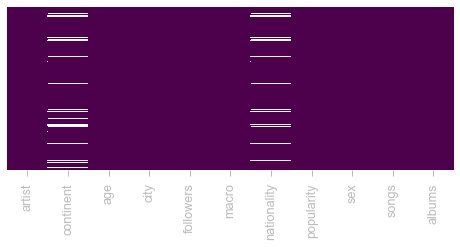

In [5]:
plt.figure(figsize=(8,3))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap= 'BuPu_r')
plt.show()

In [6]:
df.isnull().sum()

artist           0
continent      287
age              0
city             0
followers        0
macro            0
nationality    202
popularity       0
sex              0
songs            0
albums           0
dtype: int64

In [7]:
# Il data frame è gia stato filtrato automaticamente nello script DF artist.py. Rimangono soltanto pochi
# valori nulli riguardo alle nazionalità e ai continenti (calcolati sulla base delle nazionalità).

In [8]:
df.dropna(inplace=True)

In [9]:
# Si nota che tutte le variabili presentano asimmetria positiva.
# Si osserva una forte varianza interna alla variabile popularity che indica quindi grande variazione dovuta
# agli outlier così come la variabile followers.

df.describe()

,age,followers,popularity,songs,albums
count,2448.000000,2.448000e+03,2448.000000,2448.000000,2448.000000
mean,41.090278,1.731205e+06,69.325163,273.103350,33.350082
std,17.692061,3.734969e+06,7.794698,307.717745,25.386163
min,0.000000,6.880000e+02,60.000000,0.000000,0.000000
25%,30.000000,3.408718e+05,63.000000,82.750000,16.000000
50%,39.000000,6.663295e+05,67.000000,176.000000,27.000000
75%,51.000000,1.561465e+06,74.000000,338.000000,43.000000
max,94.000000,6.446456e+07,100.000000,2670.000000,258.000000


In [10]:
# Ovviamente le correlazioni più elevate sono quelle tra numero di canzoni e album e quella tra followers e 
# popolarità. Le altre correlazioni non sembrano essere degne di nota.

df.corr()

,age,followers,popularity,songs,albums
age,1.000000,-0.079390,-0.194854,0.264373,0.118746
followers,-0.079390,1.000000,0.629910,0.049434,0.157829
popularity,-0.194854,0.629910,1.000000,-0.010945,0.131723
songs,0.264373,0.049434,-0.010945,1.000000,0.730641
albums,0.118746,0.157829,0.131723,0.730641,1.000000


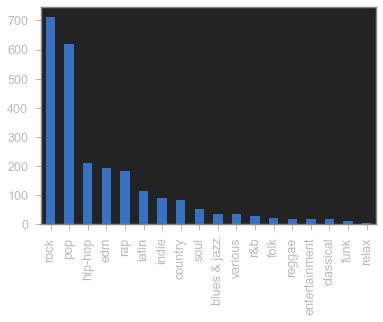

In [11]:
# Vengono visualizzati ora il raggruppamento per genere musicale: metà degli artisti sono
# raggruppati tra pop e rock.

df['macro'].value_counts().plot(kind='bar')
plt.show()

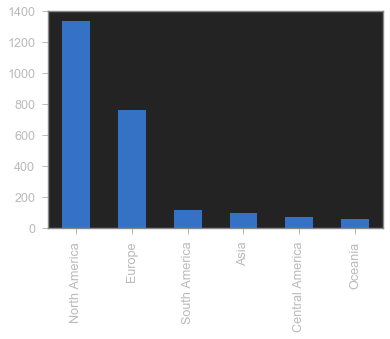

In [12]:
# Si osserva il conteggio degli artisti per continente che sono stati utilizzati nel Sankey diagram.

df['continent'].value_counts().plot(kind='bar')
plt.show()

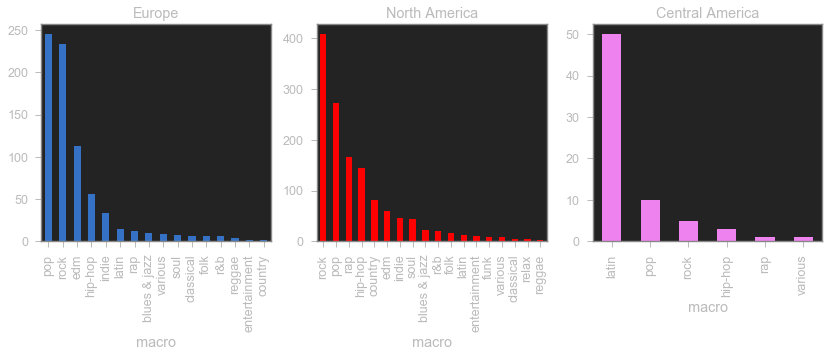

In [13]:
step = df.groupby(['continent','macro']).size().reset_index().rename(columns={0:'count'})
fig, axes = plt.subplots(1, 3,figsize=(14,4))
step[step['continent']=='Europe'].sort_values('count',ascending=False).plot(x='macro',legend=False,
                                                                    kind='bar',ax=axes[0]).title.set_text('Europe')
step[step['continent']=='North America'].sort_values('count',ascending=False).plot(x='macro',legend=False,
                                                                                   kind='bar',ax=axes[1],color='red').title.set_text('North America')
step[step['continent']=='Central America'].sort_values('count',ascending=False).plot(x='macro',legend=False,
                                                                                   kind='bar',ax=axes[2],color='violet').title.set_text('Central America')
plt.show()

In [14]:
# Si può notare come in Europa ci siano più artisti EDM o di musica elettronica: il nord Europa ha dato
# i natali a molti DJ di fama internazionale. Spicca invece per gli USA una forte produzione di musica
# Rock e Pop. Ovviamente il Centro america spicca per una vasta produzione di musica Latino/Reggaeton.

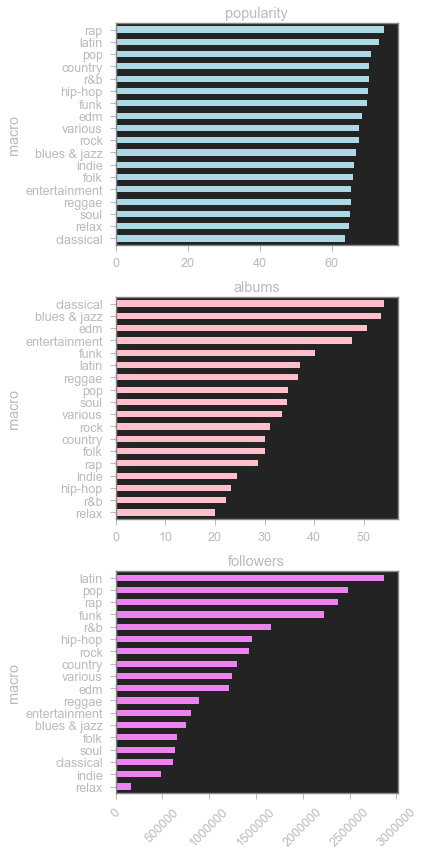

In [15]:
fig, axes = plt.subplots(3, 1,figsize=(6,12))
var = ['popularity','albums','followers']
col = ['lightblue','pink','violet']
for n, v, c in zip(range(3),var,col):
    df.groupby('macro')[v].mean().sort_values().plot(kind='barh', color=c,ax=axes[n]).title.set_text(v)
    plt.xticks(rotation=45)
    #print(df.groupby('genre')[v].mean().sort_values())
plt.tight_layout()

In [16]:
# Dai grafici appena proposti si osserva che mediamente il genere latin presenta il maggior numero 
# di followers. Per quanto riguarda invece il rock, il più popolato tra i gruppi, si trova in una posizione 
# più bassa. Mediamente la popolarità piu alta la presenta il genere rap.

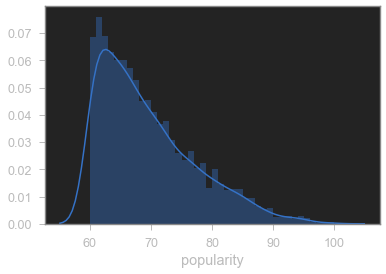

In [17]:
# Come ci si poteva aspettare c'è una forte asimmetria positiva dettata dal fatto che la grande
# maggioranza degli artisti presenta una popolarità inferiore a 70.

sns.distplot(df.popularity,bins=40)
plt.show()

In [18]:
df1 = df[df.popularity < 70]
df2 = df[df.popularity >= 70]

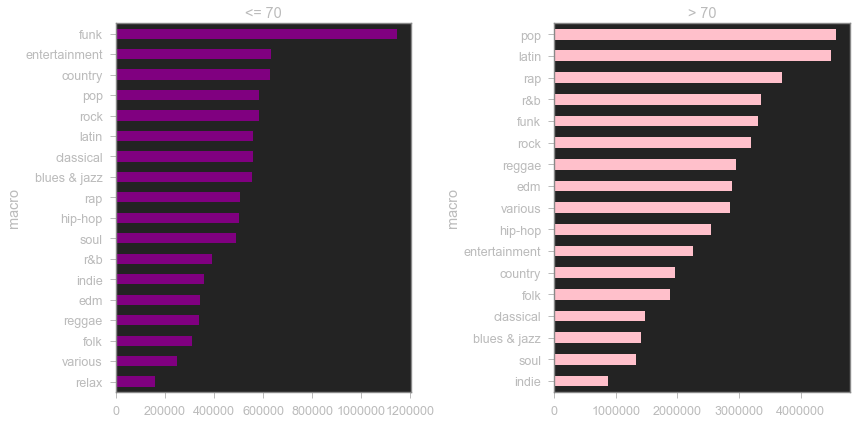

In [19]:
fig, axes = plt.subplots(1, 2,figsize=(12,6))
df[df.popularity < 70].groupby('macro')['followers'].mean().sort_values().plot(kind='barh', color='purple',ax=axes[0]).title.set_text('<= 70')
df[df.popularity >= 70].groupby('macro')['followers'].mean().sort_values().plot(kind='barh', color='pink',ax=axes[1]).title.set_text('> 70') 
plt.tight_layout()

In [20]:
# Dividendo il dataset in due parti, popolarità minore e maggiore di 70, si osserva come il gruppo meno 
# popolare presenta un numero medio di followers più alto per il genere funk rispetto a pop che risiede in 
# 4 posizione.

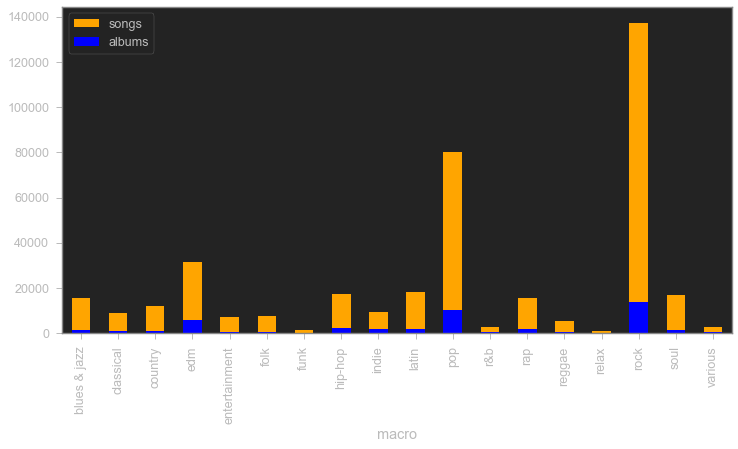

In [21]:
plt.figure(figsize=(12,6))
df1.groupby('macro').songs.sum().plot(kind='bar',color='orange')
df1.groupby('macro').albums.sum().plot(kind='bar',color='blue')
plt.legend()
plt.show()

In [22]:
# Si osserva come il genere con più album e con più canzoni prodotte sia il rock. 

In [23]:
test = pd.DataFrame(db.FINALE.aggregate([
                         {"$unwind": { "path": "$Albums", "preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks", "preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks.variables","preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks.songaname","preserveNullAndEmptyArrays": True}} ,
                         {"$unwind": { "path": "$Albums.tracks.released","preserveNullAndEmptyArrays": True}},
                         {'$project':{'_id':0,'Artist':1, 'macro':1, 'sex':1,
                                     'songname':"$Albums.tracks.songname",
                                     'Energy':'$Albums.tracks.variables.energy',
                                     'Danceability': "$Albums.tracks.variables.danceability",
                                     'BPM':"$Albums.tracks.variables.tempo",
                                     'loudness':"$Albums.tracks.variables.loudness",
                                     'Acousticness':"$Albums.tracks.variables.acousticness",
                                     'Valence':"$Albums.tracks.variables.valence",
                                     'Speechiness':"$Albums.tracks.variables.speechiness",
                                     'instrumentalness':"$Albums.tracks.variables.instrumentalness",
                                     'liveness':"$Albums.tracks.variables.liveness"}}
                         ]))

In [24]:
# Tramite questa query è stato possibile scaricare tutte le variabili inerenti alle canzoni dei singoli
# artisti. Utiliziamo isin() per considerare solo gli artisti che presentano tutte le variabili.

In [25]:
test = test[test.Artist.isin(df.artist)]

In [26]:
df_v = test.groupby('macro').corr()
df_v

Energy  Danceability       BPM  loudness  \
macro                                                                       
blues & jazz Energy            1.000000      0.293156  0.192410  0.711935   
             Danceability      0.293156      1.000000  0.039392  0.265863   
             BPM               0.192410      0.039392  1.000000  0.130224   
             loudness          0.711935      0.265863  0.130224  1.000000   
             Acousticness     -0.659361     -0.277646 -0.119489 -0.390354   
...                                 ...           ...       ...       ...   
various      Acousticness     -0.587364     -0.231315 -0.151063 -0.424672   
             Valence           0.412671      0.608772  0.218059  0.374952   
             Speechiness      -0.085774      0.197062  0.000116 -0.176151   
             instrumentalness -0.165689     -0.175056 -0.037999 -0.336880   
             liveness          0.228443     -0.038077  0.046948  0.165612   

                               Acousticness   Valence  Speechiness  \
macro                                                                
blues & jazz Energy               -0.659361  0.548813     0.150594   
             Danceability         -0.277646  0.597206     0.163024   
             BPM                  -0.119489  0.241443     0.110121   
             loudness             -0.390354  0.399976    -0.011332   
             Acousticness          1.000000 -0.284877    -0.048256   
...                                     ...       ...          ...   
various      Acousticness          1.000000 -0.182931     0.069737   
             Valence              -0.182931  1.000000     0.132243   
             Speechiness           0.069737  0.132243     1.000000   
             instrumentalness      0.058417 -0.353901    -0.096708   
             liveness              0.006777  0.041557     0.067627   

                               instrumentalness  liveness  
macro                                                      
blues & jazz Energy                    0.041826  0.135458  
             Danceability              0.040918 -0.124451  
             BPM                       0.025781  0.022275  
             loudness                 -0.140304 -0.005431  
             Acousticness             -0.009067 -0.004145  
...                                         ...       ...  
various      Acousticness              0.058417  0.006777  
             Valence                  -0.353901  0.041557  
             Speechiness              -0.096708  0.067627  
             instrumentalness          1.000000 -0.171764  
             liveness                 -0.171764  1.000000  

[162 rows x 9 columns]

In [27]:
def plot_cor(df, threshold):
    box = []
    check=[]
    for elem in df.index:
        for col in df.columns:
            if df.loc[elem,col] > threshold and df.loc[elem,col] != 1:
                box.append((elem[0],elem[1], col, df.loc[elem,col]))
            elif df.loc[elem,col] < -threshold and df.loc[elem,col] != 1:
                box.append((elem[0],elem[1], col, df.loc[elem,col]))
    for element in box:
        if (element[1],element[2]) not in check:
            check.append((element[2],element[1]))
            sns.scatterplot(x=df_v[element[1]],y=df_v[element[2]]).title.set_text(element[0])
            plt.show()
            print('Correlation: ',element[3])

In [28]:
# La precedente funzione è utile per mostrarci le correlazioni principali, sopra una certa soglia, tra le
# variabili raggruppandole per genere musicale. Scegliendo una soglia di -0.8/0.8 le correlazioni più 
# interessanti sono le seguenti.

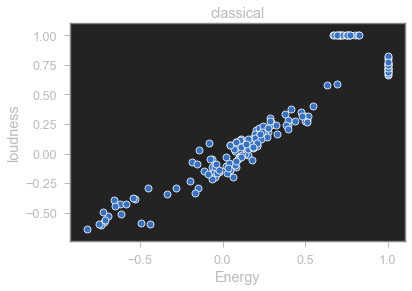

Correlation:  0.8024145201678372


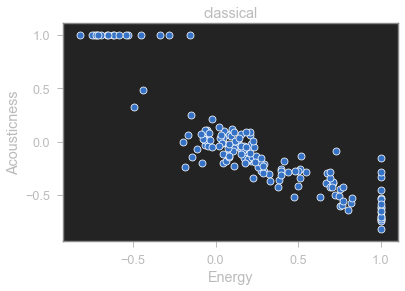

Correlation:  -0.8202953229402051


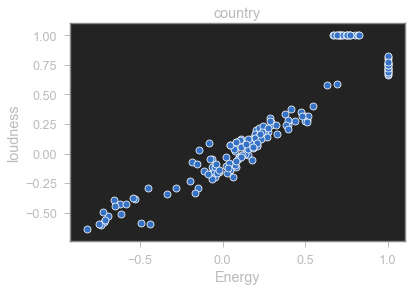

Correlation:  0.820617605981604


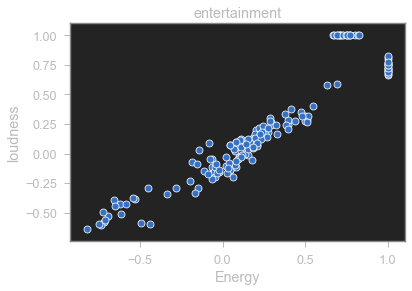

Correlation:  0.8229335895704797


In [29]:
plot_cor(df_v, 0.80)

In [30]:
def plot2genre(df, v, g):
    genres = df.index.unique()
    test.groupby(['macro','sex']).mean().loc[g[0],v].plot(kind='barh', colormap='inferno').title.set_text(g[0])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    test.groupby(['macro','sex']).mean().loc[g[1],v].plot(kind='barh', colormap='inferno').title.set_text(g[1])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

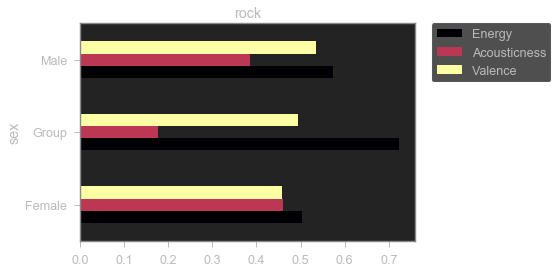

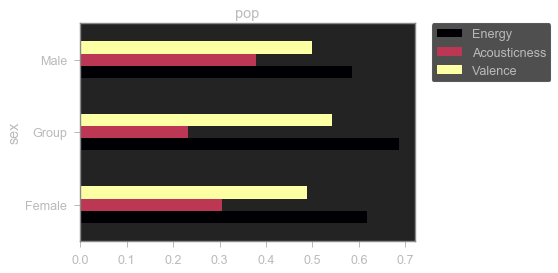

In [31]:
plot2genre(df_v, ['Energy','Acousticness','Valence'], ['rock','pop'])

In [32]:
# Si procede ora con le lyrics delle canzoni, dato che nelle visualizzazioni sono presentati i wordcloud
# degli artisti

In [33]:
test1 = pd.DataFrame(db.FINALE.aggregate([
                         {"$unwind": { "path": "$Albums", "preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks", "preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks.lyrics","preserveNullAndEmptyArrays": True}},
                         {"$unwind": { "path": "$Albums.tracks.language","preserveNullAndEmptyArrays": True}},
                         {'$project':{'_id':0,'Artist':1, 'macrogen':1, 
                                     'lyrics':"$Albums.tracks.lyrics",
                                     'language':"$Albums.tracks.language"
                                     }}
                         ]))

In [34]:
test1['lyrics'] = test1['lyrics'].apply(lambda x : np.nan if x == '' else x)

In [ ]:
# nelle prossime celle, analisi dei null e successivo drop 

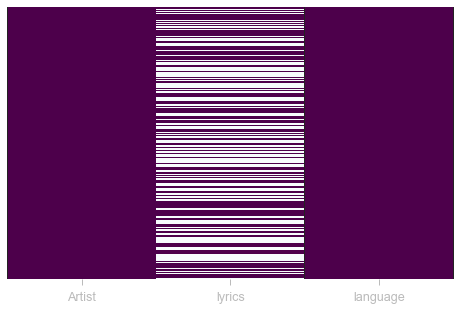

In [35]:
plt.figure(figsize=(8,5))
sns.heatmap(test1.isnull(),cbar=False,yticklabels=False,cmap= 'BuPu_r')
plt.show()

In [ ]:
# lyrics rimanenti

In [36]:
test1.dropna(inplace=True)
len(test1)

834534

In [ ]:
# split per ogni riga che rappresenta una canzone
# split di ogni parola della canzone

In [37]:
test1['count'] = test1['lyrics'].apply(lambda x: len(x.split()))

In [38]:
test1 = test1.groupby('Artist')['count'].sum().reset_index()

In [39]:
test1.rename(columns={'Artist':'artist'}, inplace=True)

In [40]:
wordxartist = test1.merge(df[['artist','macro','songs']],'inner','artist')

In [ ]:
# non si prende relax perchè erano presenti alcuni testi (scaricati per errore) scorrelati dalla canzone
# il genere in teoria è completamente senza parole, quindi non viene considerato

In [41]:
wordxartist['mean_words'] = wordxartist['count']/wordxartist['songs']
wordxartist.drop_duplicates(inplace=True)
wordxartist.sort_values('mean_words',ascending=False, inplace=True)
wordxartist = wordxartist[wordxartist['macro']!='relax']
wordxartist.head()

,artist,count,macro,songs,mean_words
135,André 3000,6540,hip-hop,7,934.285714
217,Bad Meets Evil,17779,rap,22,808.136364
1919,Sexion D'Assaut,103955,pop,134,775.783582
1106,Joyner Lucas,57361,hip-hop,77,744.948052
930,Hopsin,93162,hip-hop,126,739.380952


In [ ]:
# artisti con maggior numero di parole per canzone in media (principalmente hip hop e rap)

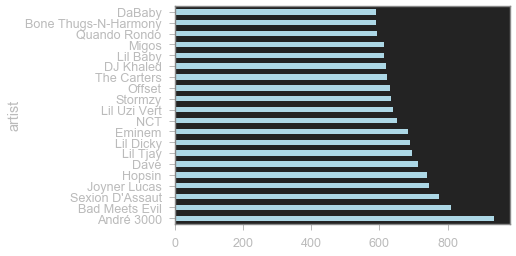

In [42]:
wordxartist.head(20).plot(x='artist',y ='mean_words',kind='barh',color='lightblue',legend=False)
plt.show()

In [43]:
mappa = pd.read_csv('file/mappa.csv', index_col = 0)

In [44]:
defintivo = pd.pivot_table(mappa, values='Streams', index='Artist', columns='date', aggfunc= np.sum)
defintivo.head()

date,04/08/2020,09/08/2020,10/07/2020,14/08/2020,15/07/2020,20/07/2020,25/07/2020,30/07/2020
Artist,,,,,,,,
"""Weird Al"" Yankovic",287654.0,286491.0,283368.0,286474.0,283368.0,287800.0,288276.0,287654.0
(G)I-DLE,1110631.0,1130271.0,1099874.0,1176814.0,1099874.0,1128217.0,1161698.0,1186890.0
*NSYNC,2004089.0,2002482.0,2097316.0,2011295.0,2097316.0,2072347.0,2073982.0,2065332.0
070 Shake,862098.0,1012838.0,645878.0,1117815.0,645878.0,634411.0,628419.0,862098.0
100 gecs,816603.0,879779.0,348444.0,881119.0,519935.0,660453.0,732326.0,816603.0


In [45]:
definitivo = defintivo[['10/07/2020','15/07/2020','20/07/2020','25/07/2020','30/07/2020','04/08/2020','09/08/2020','14/08/2020']]

In [46]:
definitivo['tasso %'] = (definitivo['14/08/2020']/definitivo['10/07/2020'])*100
definitivo.reset_index(inplace=True)

In [ ]:
# Questo tasso di crescita è stato calcolato rapportando l'ultima osservazione relativa agli streams di 
# ogni artista rispetto all'osservazione più recente. Questo tasso di crescita mostra l'incremento netto
# tra il primo e l'ultimo giorno.

In [47]:
value = []
for k,artist in tqdm(enumerate(definitivo['Artist'])):
    h = []
    for i in range(0,7):
        h.append(definitivo.iloc[k,1:-1][i+1]/definitivo.iloc[k,1:-1][i])
    value.append(pd.Series(h).mean()-1)

2829it [00:13, 206.87it/s]


In [48]:
definitivo['new tasso %'] = pd.Series(value)*100

In [49]:
definitivo.sort_values('new tasso %',ascending=False)

date,Artist,10/07/2020,15/07/2020,20/07/2020,25/07/2020,30/07/2020,04/08/2020,09/08/2020,14/08/2020,tasso %,new tasso %
872,Fenix Flexin,209160.0,209160.0,259249.0,446028.0,677669.0,665395.0,936101.0,1127197.0,538.916141,29.602056
1874,OHGEESY,245217.0,245217.0,292326.0,468976.0,570858.0,559416.0,858575.0,1068962.0,435.924915,25.334498
4,100 gecs,348444.0,519935.0,660453.0,732326.0,816603.0,816603.0,879779.0,881119.0,252.872485,15.217365
1580,MNEK,1926788.0,1926788.0,2267593.0,2871510.0,3347472.0,3297772.0,3914755.0,4699289.0,243.892374,14.022912
536,Clueso,942977.0,942977.0,924752.0,908545.0,1334137.0,1316708.0,1613395.0,1889914.0,200.419947,11.646144
...,...,...,...,...,...,...,...,...,...,...,...
2372,TWICE,2475467.0,2353390.0,2261711.0,2141482.0,2004866.0,1875763.0,1797280.0,1762491.0,71.198323,-4.725946
1860,Noname,969289.0,1010963.0,847767.0,742874.0,742874.0,689730.0,689730.0,676966.0,69.841502,-4.745780
2210,Scotty McCreery,NaN,1703227.0,1594164.0,1437576.0,1339287.0,1339287.0,1269214.0,1240477.0,NaN,-5.093216
1447,Lauren Bennett,9752.0,9752.0,9404.0,8984.0,8455.0,8025.0,7472.0,6722.0,68.929450,-5.133874


In [ ]:
# Questo secondo tasso è stato calcolato come numero indice a base mobile rapportando ogni ascolto a quello
# del giorno successimo. Indicatore più robusto usato nella quadrant matrix.

In [50]:
definitivo.sort_values('new tasso %',ascending=False, inplace=True)
definitivo.set_index('Artist',inplace=True)

In [51]:
def plot_trend(artist, df):
    dates = pd.to_datetime(df.columns[0:-2], format='%d/%m/%Y')
    print('{} growth rate: {}%'.format(artist, round(df.loc[artist,'new tasso %'])))
    sns.lineplot(x = list(dates),y=df.loc[artist,'10/07/2020':'14/08/2020'].values).title.set_text(artist)
    plt.xticks(rotation=45)
    plt.show()

In [52]:
df2 = mappa.groupby('Artist')['Streams'].sum().reset_index()

In [53]:
step = df2.merge(definitivo.reset_index()[['Artist','new tasso %']],'inner','Artist')

In [54]:
df3 = df[df.artist.isin(definitivo.index[:20])].merge(step.rename(columns={'Artist':'artist'}),
                                                'inner', 'artist')
df4 = df3.sort_values('new tasso %',ascending=False)

In [ ]:
# Viene ora proposta la funzione che permette di plottare i trend degli ascolti, in questo caso sono stati
# scelti i 5 artisti con il tasso di crescita più alto.

MNEK growth rate: 14.0%


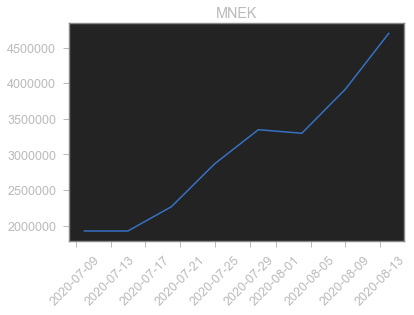

Clueso growth rate: 12.0%


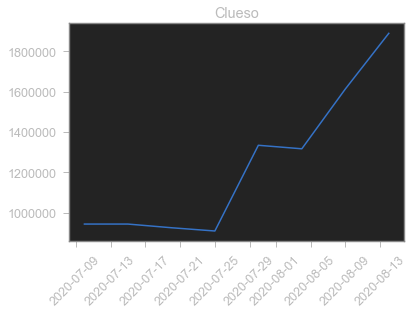

Jasmine Thompson growth rate: 10.0%


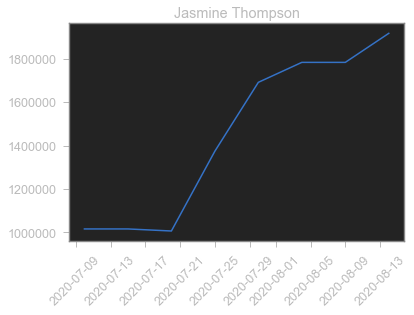

DJ Khaled growth rate: 9.0%


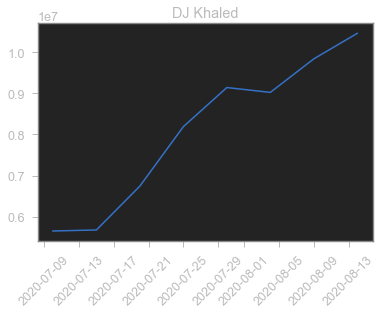

Pietro Lombardi growth rate: 9.0%


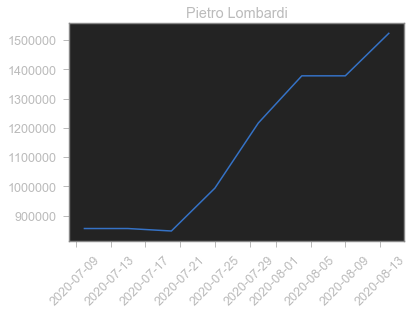

In [55]:
for artist in df4.artist[:5]:
    plot_trend(artist, definitivo)